# Baseline - Train and Save Best Case

## Set Up

In [103]:
import warnings
warnings.filterwarnings("ignore")

In [104]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import json
from scipy.sparse import load_npz

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[2]))

from scripts.utils import tune_thresholds


In [105]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/external/crpwarner/merged')
SAVE_PATH = os.path.join(PATH, 'models/1_groundtruth_with_large')

### MPL

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [107]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

## Best Binary Model by Class

### Mint

In [108]:
df = pd.read_csv(os.path.join(DATA_PATH, 'mint.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,1
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,1


In [109]:
y = np.array([df['TP?']]).T

In [110]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

#### Opcode Frequency

In [111]:
from scripts.feature_extractions.opcode_freq import get_opcodes_freq_from_files

In [112]:
from sklearn.neighbors import KNeighborsClassifier

In [113]:
X  = get_opcodes_freq_from_files(hex_files)
cols = X.columns
X.head()

  4%|▍         | 7/161 [00:00<00:14, 10.69it/s]invalid instruction: PUSH18
invalid instruction: PUSH32
invalid instruction: PUSH31
invalid instruction: PUSH27
  7%|▋         | 12/161 [00:00<00:07, 18.63it/s]invalid instruction: PUSH27
invalid instruction: PUSH25
 11%|█         | 18/161 [00:00<00:05, 27.06it/s]invalid instruction: PUSH32
invalid instruction: PUSH30
invalid instruction: PUSH32
 14%|█▎        | 22/161 [00:00<00:04, 29.30it/s]invalid instruction: PUSH15
invalid instruction: PUSH22
invalid instruction: PUSH24
 16%|█▌        | 26/161 [00:01<00:05, 22.90it/s]invalid instruction: PUSH30
invalid instruction: PUSH16
invalid instruction: PUSH31
invalid instruction: PUSH31
 20%|█▉        | 32/161 [00:01<00:04, 29.43it/s]invalid instruction: PUSH15
invalid instruction: PUSH17
 24%|██▎       | 38/161 [00:01<00:03, 35.23it/s]invalid instruction: PUSH28
invalid instruction: PUSH18
invalid instruction: PUSH19
invalid instruction: PUSH24
invalid instruction: PUSH23
 28%|██▊       | 45/1

,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,DIV,AND,DUP,...,SIGNEXTEND,DELEGATECALL,SELFDESTRUCT,SGT,BASEFEE,EXTCODECOPY,MULMOD,XOR,DIFFICULTY,SDIV
address,,,,,,,,,,,,,,,,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,701,103.0,15,10.0,75,27.0,372,20.0,118.0,565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x8275ebf521dc217aa79c88132017a5bcef001dd9,674,112.0,10,7.0,53,17.0,326,15.0,150.0,446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,664,115.0,10,8.0,63,7.0,172,2.0,47.0,312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,1155,179.0,23,13.0,101,7.0,264,4.0,76.0,517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,419,78.0,8,13.0,36,15.0,200,6.0,40.0,302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Train Model

In [115]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

##### Evaluate Model

In [116]:
y_pred = model.predict(X_test)

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.74      0.77      0.76        22

    accuracy                           0.67        33
   macro avg       0.62      0.61      0.62        33
weighted avg       0.66      0.67      0.66        33



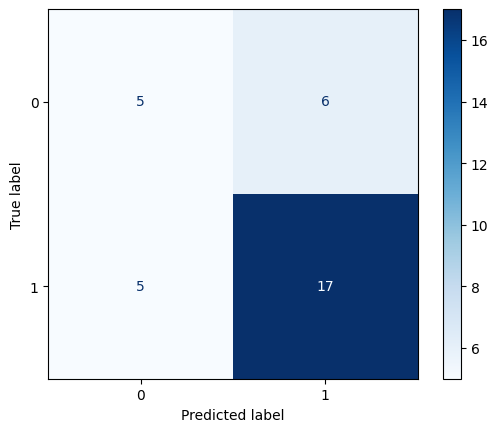

In [118]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [119]:
score = f1_score(y_test, y_pred, average='macro')
name = f"mint-tf-idf-f1-{score:2f}"
with open(os.path.join(SAVE_PATH, fr"{name}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}.pkl")

Saved mint-tf-idf-f1-0.615873.pkl


In [120]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols), fout, indent=2)

#### TF-IDF (Source Code)

In [121]:
from scripts.feature_extractions.tf_idf import get_tf_idf_vector

In [122]:
X, cols  = get_tf_idf_vector(sol_files)
X

100%|██████████| 161/161 [00:00<00:00, 14732.59it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 47170 stored elements and shape (161, 2000)>

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Train Model

In [124]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

##### Evaluate Model

In [125]:
y_pred = model.predict(X_test)

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       1.00      0.59      0.74        22

    accuracy                           0.73        33
   macro avg       0.78      0.80      0.73        33
weighted avg       0.85      0.73      0.73        33



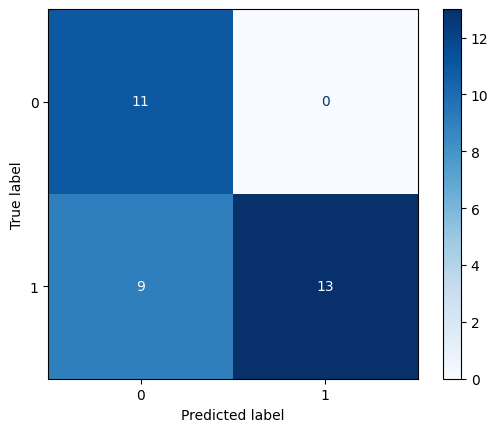

In [127]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [128]:
score = f1_score(y_test, y_pred, average='macro')
name = f"mint-tf-idf-f1-{score:2f}"
with open(os.path.join(SAVE_PATH, fr"{name}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}.pkl")

Saved mint-tf-idf-f1-0.726267.pkl


In [129]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols), fout, indent=2)

### Leak

In [130]:
df = pd.read_csv(os.path.join(DATA_PATH, 'leak.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,0
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,0


In [131]:
y = np.array([df['TP?']]).T

In [132]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

#### TF-IDF (Source Code)

In [133]:
from lightgbm import LGBMClassifier

In [134]:
X, cols  = get_tf_idf_vector(sol_files, 3000)
X

100%|██████████| 156/156 [00:00<00:00, 13116.92it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 49442 stored elements and shape (156, 3000)>

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Train Model

In [136]:
model = LGBMClassifier(random_state=42)
# model = DecisionTreeClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9962
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 587
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=42)

##### Evaluate Model

In [137]:
y_pred = model.predict(X_test)

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71        14
           1       0.80      0.67      0.73        18

    accuracy                           0.72        32
   macro avg       0.72      0.73      0.72        32
weighted avg       0.73      0.72      0.72        32



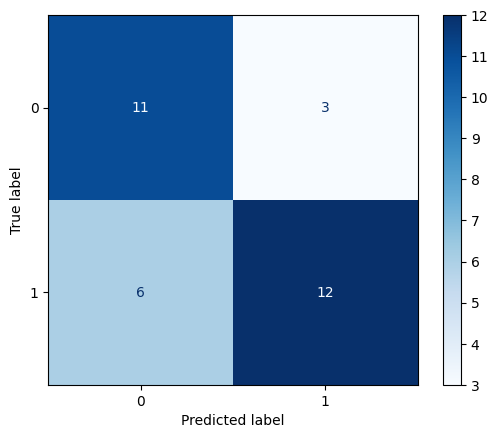

In [139]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [140]:
score = f1_score(y_test, y_pred, average='macro')
name = f"leak-tf-idf-f1-{score:2f}"
with open(os.path.join(SAVE_PATH, fr"{name}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}.pkl")

Saved leak-tf-idf-f1-0.718475.pkl


In [141]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols), fout, indent=2)

### Limit 

In [142]:
df = pd.read_csv(os.path.join(DATA_PATH, 'limit.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,1
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,1
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,1


In [143]:
y = np.array([df['TP?']]).T

In [144]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

#### Opcode Frequency

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [146]:
X  = get_opcodes_freq_from_files(hex_files)
cols = list(X.columns)
X.head()

  0%|          | 0/160 [00:00<?, ?it/s]invalid instruction: PUSH30
invalid instruction: PUSH16
  6%|▋         | 10/160 [00:00<00:03, 43.10it/s]invalid instruction: PUSH20
invalid instruction: PUSH11
invalid instruction: PUSH19
  9%|▉         | 15/160 [00:00<00:08, 17.80it/s]invalid instruction: PUSH5
invalid instruction: PUSH28
 11%|█▏        | 18/160 [00:00<00:07, 19.28it/s]invalid instruction: PUSH29
invalid instruction: PUSH30
 13%|█▎        | 21/160 [00:00<00:06, 21.28it/s]invalid instruction: PUSH25
invalid instruction: PUSH17
invalid instruction: PUSH26
invalid instruction: PUSH28
invalid instruction: PUSH29
 16%|█▋        | 26/160 [00:01<00:04, 27.46it/s]invalid instruction: PUSH21
invalid instruction: PUSH28
invalid instruction: PUSH13
 22%|██▏       | 35/160 [00:01<00:05, 24.19it/s]invalid instruction: PUSH30
invalid instruction: PUSH16
invalid instruction: PUSH29
invalid instruction: PUSH27
invalid instruction: PUSH29
 25%|██▌       | 40/160 [00:01<00:04, 28.21it/s]invalid in

,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,DIV,AND,DUP,...,SELFDESTRUCT,BALANCE,CALLCODE,MULMOD,DELEGATECALL,SIGNEXTEND,DIFFICULTY,BASEFEE,SGT,SDIV
address,,,,,,,,,,,,,,,,,,,,,
0x8275ebf521dc217aa79c88132017a5bcef001dd9,674,112.0,10.0,7.0,53,17.0,326,15.0,150.0,446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,664,115.0,10.0,8.0,63,7.0,172,2.0,47.0,312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,1155,179.0,23.0,13.0,101,7.0,264,4.0,76.0,517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,419,78.0,8.0,13.0,36,15.0,200,6.0,40.0,302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7,1248,249.0,20.0,29.0,100,35.0,556,7.0,143.0,839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Train Model

In [ ]:
model = ExtraTreesClassifier(random_state=42)
model.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

##### Evaluate Model

In [149]:
y_pred = model.predict(X_test)

In [150]:
print(classification_report(y_test, y_pred))
cr = classification_report(y_test, y_pred, output_dict=True)
print(cr['macro avg']['f1-score'])

              precision    recall  f1-score   support

           0       0.40      0.75      0.52         8
           1       0.88      0.62      0.73        24

    accuracy                           0.66        32
   macro avg       0.64      0.69      0.63        32
weighted avg       0.76      0.66      0.68        32

0.6267232237539766


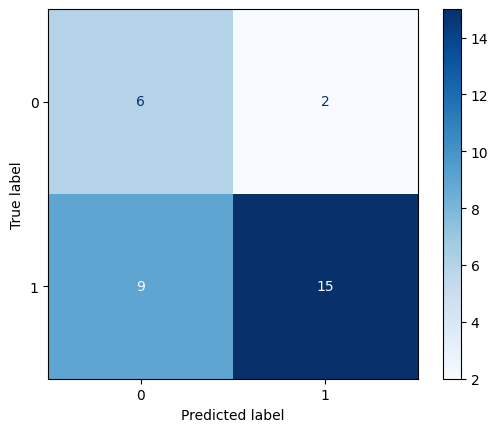

In [151]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [152]:
score = f1_score(y_test, y_pred, average='macro')
name = f"leak-tf-idf-f1-{score:2f}"
with open(os.path.join(SAVE_PATH, fr"{name}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}.pkl")

Saved leak-tf-idf-f1-0.626723.pkl


In [153]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols), fout, indent=2)